In [81]:
from transformers import AutoModelForImageSegmentation
from torchvision.transforms.functional import normalize
import torch.nn.functional as F
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load the model
model = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4", trust_remote_code=True)

# Save the model locally
model_directory = "./RMBG_Model"  # Specify the directory where you want to save the model
model.save_pretrained(model_directory)

In [68]:
def preprocess_image(im: np.ndarray, model_input_size: list) -> torch.Tensor:
    if len(im.shape) < 3:
        im = im[:, :, np.newaxis]
    # orig_im_size=im.shape[0:2]
    im_tensor = torch.tensor(im, dtype=torch.float32).permute(2,0,1)
    im_tensor = F.interpolate(torch.unsqueeze(im_tensor,0), size=model_input_size, mode='bilinear')
    image = torch.divide(im_tensor,255.0)
    image = normalize(image,[0.5,0.5,0.5],[1.0,1.0,1.0])
    return image

def postprocess_image(result: torch.Tensor, im_size: list)-> np.ndarray:
    result = torch.squeeze(F.interpolate(result, size=im_size, mode='bilinear') ,0)
    ma = torch.max(result)
    mi = torch.min(result)
    result = (result-mi)/(ma-mi)
    im_array = (result*255).permute(1,2,0).cpu().data.numpy().astype(np.uint8)
    im_array = np.squeeze(im_array)
    return im_array

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


BriaRMBG(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReL

In [69]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

def plot_rect(image, x_min, y_min, width, height, ax):

    
    
    ax.imshow(image)
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 5, "Label", color="red", fontsize=10)

    ax.axis('off')

In [72]:
from skimage import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def run_model(img_path):
    # Read the image and convert it to RGB format
    orig_im = Image.open(img_path).convert("RGB")
    orig_im = np.array(orig_im)  # Convert PIL Image back to numpy array
    
    orig_im_size = orig_im.shape[0:2]
    model_input_size = orig_im_size
    image = preprocess_image(orig_im, model_input_size).to(device)
    result = model(image)
    result_image = postprocess_image(result[0][0], orig_im_size)
    mask = result_image
    
    # Create the final image
    final_img = np.zeros_like(orig_im)
    for i, row in enumerate(orig_im):
        for j, pixel in enumerate(row):
            if (mask[i][j] / 255 > 0.4):
                filter = mask[i][j] / 255
                final_img[i][j][0] = np.ceil(pixel[0] * filter)
                final_img[i][j][1] = np.ceil(pixel[1] * filter)
                final_img[i][j][2] = np.ceil(pixel[2] * filter)
            else:
                final_img[i][j][0] = 255
                final_img[i][j][1] = 255
                final_img[i][j][2] = 255
    
    # Plot the original and final images
    plt.figure(figsize=(40, 30))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_im)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()


In [73]:
run_model(img_path = r'C:\Users\sashr\OneDrive\Desktop\nirma\3rd year\semester 5\ML\SVM notes\Screenshot 2024-12-08 162143.png')

KeyboardInterrupt: 

In [74]:
def run_pipeline(image, x_min, y_min, width, height, total_run):
    # Read the image
    image = image.convert("RGB") 
    image_array = np.array(image)
    
    # Set up the white background image
    white_background = np.ones_like(image_array, dtype=np.uint8) * 255
    white_background[y_min:y_min+height, x_min:x_min+width] = image_array[y_min:y_min+height, x_min:x_min+width]
    cropped_image_region = image_array[y_min:y_min+height, x_min:x_min+width]

    orig_im = np.array(cropped_image_region)
    orig_im_size = orig_im.shape[0:2]
    model_input_size = orig_im_size

    # Set the initial image to be processed
    current_image = preprocess_image(orig_im, model_input_size).to(device)
    
    for run in range(total_run):
        # Run the model
        result = model(current_image)
        result_image = postprocess_image(result[0][0], orig_im_size)
        mask = result_image

        # Apply the mask to the image
        final_img = np.zeros_like(orig_im)
        for i, row in enumerate(orig_im): 
            for j, pixel in enumerate(row): 
                if (mask[i][j] / 255 > 0.8):
                    filter = mask[i][j] / 255
                    final_img[i][j][0] = np.ceil(pixel[0] * filter) 
                    final_img[i][j][1] = np.ceil(pixel[1] * filter)
                    final_img[i][j][2] = np.ceil(pixel[2] * filter)
                else: 
                    final_img[i][j][0] = 255 
                    final_img[i][j][1] = 255 
                    final_img[i][j][2] = 255 
        
        # Update the current image for the next iteration
        # Place the processed final image back into the region of interest on the white background
        white_image = np.ones_like(image_array, dtype=np.uint8) * 255
        white_image[y_min:y_min+height, x_min:x_min+width] = final_img
        final_image = Image.fromarray(white_image)

        # Update the image to be used in the next iteration
        # Crop the processed region again and prepare it for the next pass
        cropped_image_region = final_img
        orig_im = np.array(cropped_image_region)
        current_image = preprocess_image(orig_im, model_input_size).to(device)
    
    # Return the final processed image after all iterations
    return final_image

In [76]:
x_min, y_min, width, height = 500, 640, 340, 330
image_path = r"C:\Users\sashr\OneDrive\Desktop\nirma\3rd year\semester 5\ML\SVM notes\Screenshot 2024-12-08 162143.png"
image = Image.open(image_path)
fig, axes = plt.subplots(1, 2, figsize=(15, 30))
plot_rect(image, x_min, y_min, width, height, axes[0])
final = run_pipeline(image, x_min, y_min, width, height , 3)
axes[1].imshow(final)
axes[1].axis('off')  
plt.show()

KeyboardInterrupt: 

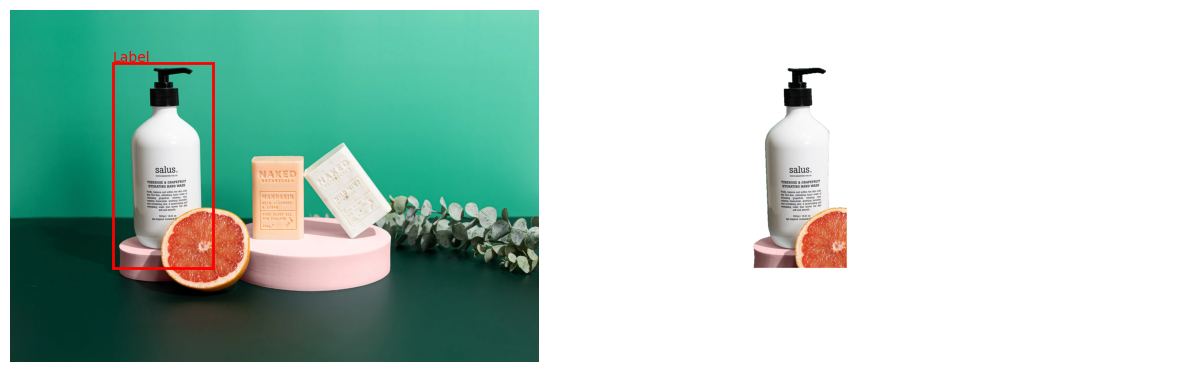

In [130]:
x_min, y_min, width, height = 350, 180, 340, 700
image_path = "/kaggle/input/products/2_e822dae0-14df-4cb8-b145-ea4dc0966b34.webp"
image = Image.open(image_path)
fig, axes = plt.subplots(1, 2, figsize=(15, 30))
plot_rect(image, x_min, y_min, width, height, axes[0])
final = run_pipeline(image, x_min, y_min, width, height , 3)
axes[1].imshow(final)
axes[1].axis('off')  
plt.show()

In [77]:
from PIL import Image
import numpy as np
from skimage import io

def resize_image_and_adjust_bbox(image_path,x_min, y_min, width, height ,  target_width=400, target_height=300):

    image = np.array(Image.open(image_path))
    original_height, original_width = image.shape[:2]

    resized_image = Image.fromarray(image)
    resized_image = resized_image.resize((target_width, target_height), Image.LANCZOS)
    resized_image_array = np.array(resized_image)
 
    scale_x = target_width / original_width
    scale_y = target_height / original_height

    x_min_resized = int(x_min * scale_x)
    y_min_resized = int(y_min * scale_y)
    width_resized = int(width * scale_x)
    height_resized = int(height * scale_y)

    return resized_image_array, (x_min_resized, y_min_resized, width_resized, height_resized) , (original_width , original_height)


In [78]:
def resize_to_original(image, x_min, y_min, width, height, original_width, original_height, target_width=400, target_height=300):
    # Ensure 'image' is a valid image array (not a tuple)
    if isinstance(image, np.ndarray):
        resized_back_image = Image.fromarray(image).resize((original_width, original_height), Image.LANCZOS)
    else:
        raise ValueError("Provided image is not in a valid format")

    resized_back_image_array = np.array(resized_back_image)

    # Calculate scaling factors
    scale_x = original_width / target_width
    scale_y = original_height / target_height

    # Adjust bounding box coordinates and size back to the original scale
    x_min_original = int(x_min * scale_x)
    y_min_original = int(y_min * scale_y)
    width_original = int(width * scale_x)
    height_original = int(height * scale_y)

    return resized_back_image_array, (x_min_original, y_min_original, width_original, height_original)


In [79]:
def convert_to_rgb(image_path):
    image = Image.open(image_path)
    return image.convert("RGB")


In [134]:
def smooth_and_sharpen(image):
    """
    Apply smoothing to the image using Gaussian blur and then sharpen it using Laplacian filter.

    :param image: Input image (numpy array)
    :return: Processed image with smoothing and sharpening applied
    """
    # Apply Gaussian blur for smoothing
    smoothed = cv2.GaussianBlur(image, (5, 5), 0)

    # Convert to grayscale for Laplacian filter
    if len(image.shape) == 3 and image.shape[2] == 3:  # RGB image
        gray = cv2.cvtColor(smoothed, cv2.COLOR_RGB2GRAY)
    else:
        gray = smoothed

    # Apply Laplacian filter for sharpening
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # Convert Laplacian result back to RGB if original image is RGB
    if len(image.shape) == 3 and image.shape[2] == 3:
        laplacian_rgb = cv2.cvtColor(cv2.convertScaleAbs(laplacian), cv2.COLOR_GRAY2RGB)
    else:
        laplacian_rgb = cv2.convertScaleAbs(laplacian)

    # Add the Laplacian result to the smoothed image for sharpening
    sharpened = cv2.addWeighted(smoothed, 1, laplacian_rgb, -1, 0)

    return sharpened


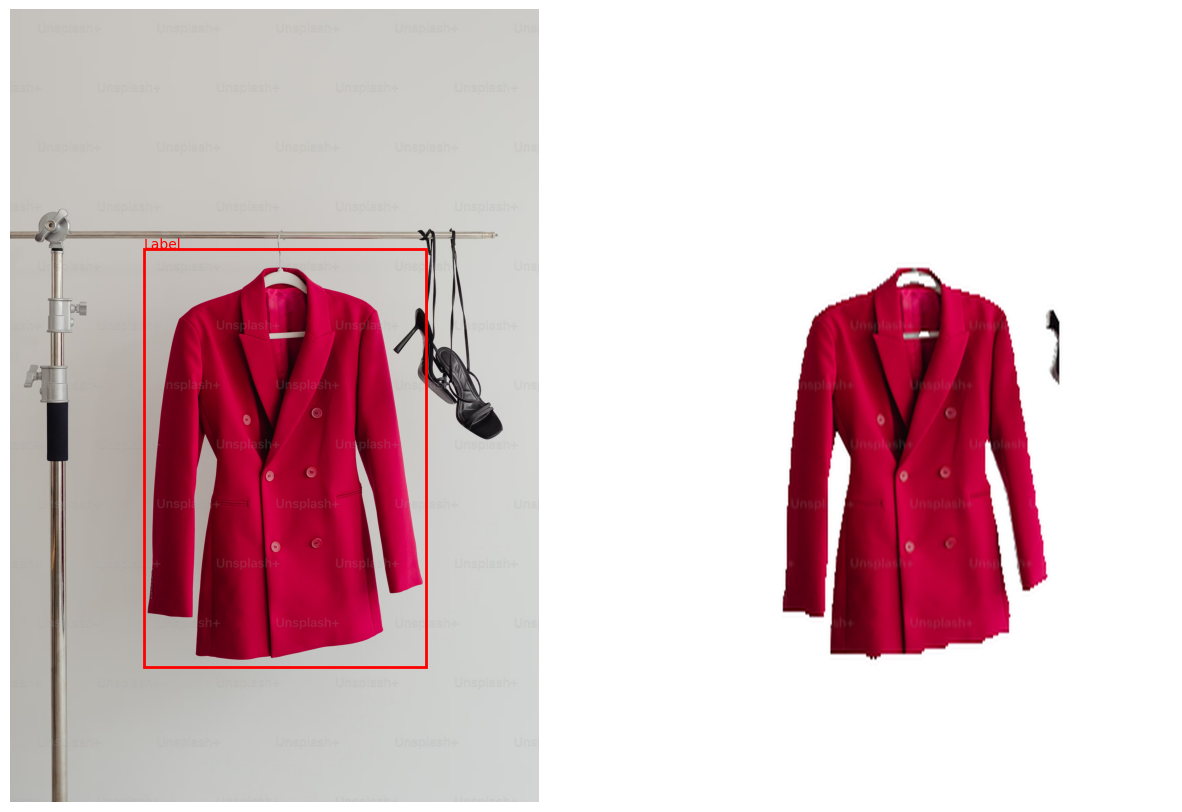

In [135]:
x_min, y_min, width, height = 780, 1400, 1650, 2440
image_path = "/kaggle/input/new-jacket/premium_photo-1675186049563-000f7ac02c44.jpg"

fig, axes = plt.subplots(1, 2, figsize=(15, 30))
plot_rect(io.imread(image_path), x_min, y_min, width, height, axes[0])

image, (x_min, y_min, width, height), (ow, oh) = resize_image_and_adjust_bbox(image_path, x_min, y_min, width, height)
image = Image.fromarray(image)
final = run_pipeline(image, x_min, y_min, width, height, 3)

final_image, (x_min_orig, y_min_orig, width_orig, height_orig) = resize_to_original(
    np.array(final), x_min, y_min, width, height, ow, oh
)

axes[1].imshow(final_image)
axes[1].axis('off')

plt.show()


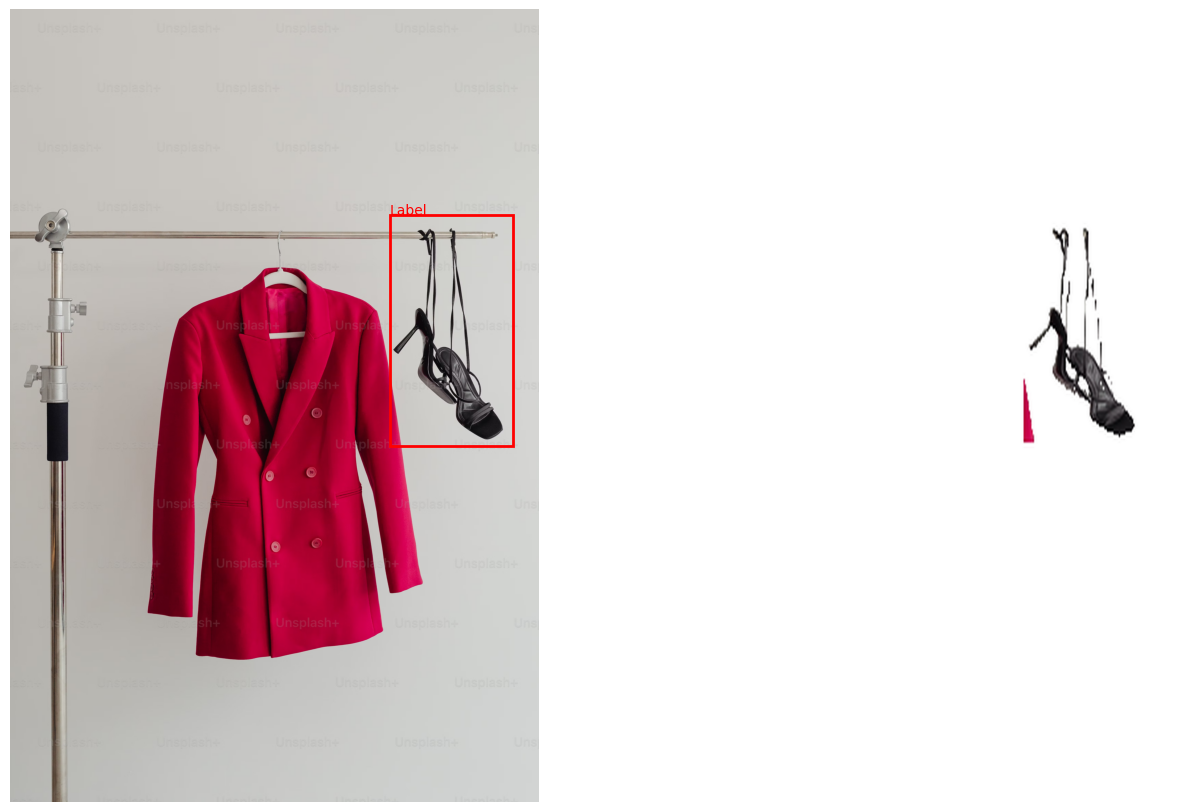

In [136]:
x_min, y_min, width, height = 2220, 1200, 720, 1350
image_path = "/kaggle/input/new-jacket/premium_photo-1675186049563-000f7ac02c44.jpg"


fig, axes = plt.subplots(1, 2, figsize=(15, 30))
plot_rect(io.imread(image_path), x_min, y_min, width, height, axes[0])

image, (x_min, y_min, width, height), (ow, oh) = resize_image_and_adjust_bbox(image_path, x_min, y_min, width, height)
image = Image.fromarray(image)
final = run_pipeline(image, x_min, y_min, width, height, 1)

final_image, (x_min_orig, y_min_orig, width_orig, height_orig) = resize_to_original(
    np.array(final), x_min, y_min, width, height, ow, oh
)

axes[1].imshow(final_image)
axes[1].axis('off')

plt.show()

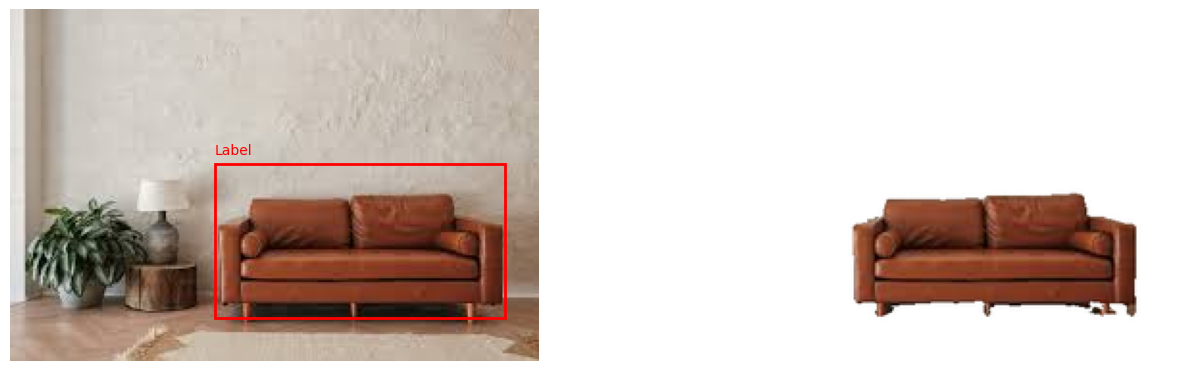

In [137]:
x_min, y_min, width, height = 106, 80, 151, 80
image_path = "//kaggle/input/sofa-photo/zxdfxgcnjhu.jpeg"

fig, axes = plt.subplots(1, 2, figsize=(15, 30))
plot_rect(io.imread(image_path), x_min, y_min, width, height, axes[0])

image, (x_min, y_min, width, height), (ow, oh) = resize_image_and_adjust_bbox(image_path, x_min, y_min, width, height)
image = Image.fromarray(image)
final = run_pipeline(image, x_min, y_min, width, height, 1)

final_image, (x_min_orig, y_min_orig, width_orig, height_orig) = resize_to_original(
    np.array(final), x_min, y_min, width, height, ow, oh
)

axes[1].imshow(final_image)
axes[1].axis('off')

plt.show()

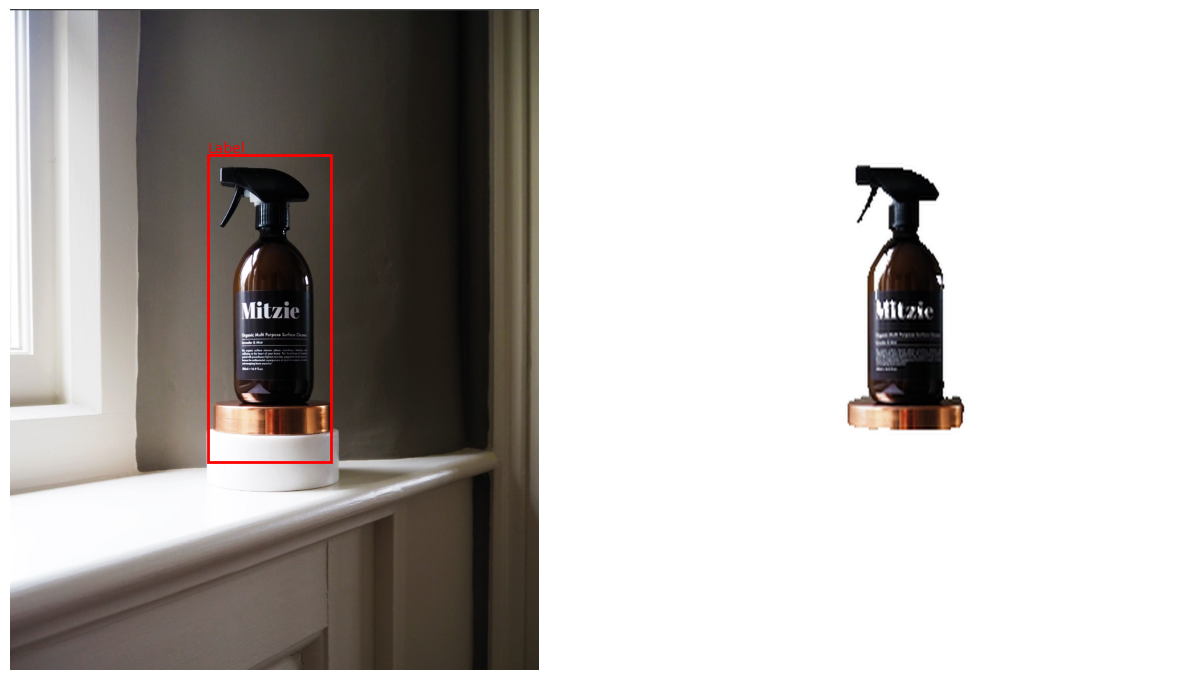

In [138]:

x_min, y_min, width, height = 450, 330, 280, 700
image_path = "/kaggle/input/oil-bottel/Screenshot 2024-12-08 160119.png"

# Plot the original image with bounding box
fig, axes = plt.subplots(1, 2, figsize=(15, 30))
plot_rect(io.imread(image_path), x_min, y_min, width, height, axes[0])

# Process image for resizing and bounding box adjustment
image, (x_min, y_min, width, height), (ow, oh) = resize_image_and_adjust_bbox(image_path, x_min, y_min, width, height)
image = Image.fromarray(image)
# Apply the pipeline (ensure input is RGB)
final = run_pipeline(image ,x_min, y_min, width, height, 2)

# Resize back to original dimensions
final_image, (x_min_orig, y_min_orig, width_orig, height_orig) = resize_to_original(
    np.array(final), x_min, y_min, width, height, ow, oh
)

# Plot the final image
axes[1].imshow(final_image)
axes[1].axis('off')

plt.show()

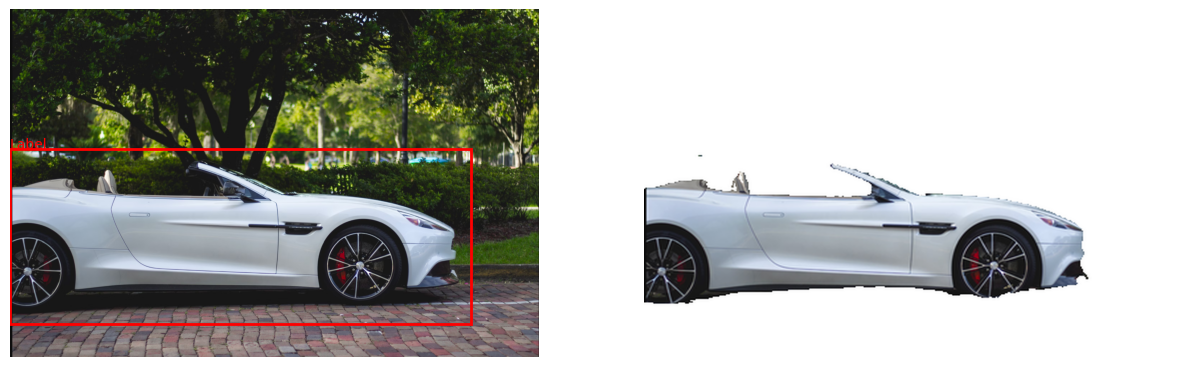

In [80]:
x_min, y_min, width, height = 0, 600, 1980, 750
image_path = r"C:\Users\sashr\OneDrive\Desktop\nirma\3rd year\semester 5\ML\SVM notes\Screenshot 2024-12-08 162143.png"

# Plot the original image with bounding box
fig, axes = plt.subplots(1, 2, figsize=(15, 30))
plot_rect(io.imread(image_path), x_min, y_min, width, height, axes[0])

# Process image for resizing and bounding box adjustment
image, (x_min, y_min, width, height), (ow, oh) = resize_image_and_adjust_bbox(image_path, x_min, y_min, width, height)
image = Image.fromarray(image)
# Apply the pipeline (ensure input is RGB)
final = run_pipeline(image ,x_min, y_min, width, height, 2)

# Resize back to original dimensions
final_image, (x_min_orig, y_min_orig, width_orig, height_orig) = resize_to_original(
    np.array(final), x_min, y_min, width, height, ow, oh
)

# Plot the final image
axes[1].imshow(final_image)
axes[1].axis('off')

plt.show()

In [144]:
def show_pipeline(img_pagt , x_min, y_min, width, height ):
    # Plot the original image with bounding box
    fig, axes = plt.subplots(1, 2, figsize=(10, 30))
    plot_rect(io.imread(image_path), x_min, y_min, width, height, axes[0])
    
    # Process image for resizing and bounding box adjustment
    image, (x_min, y_min, width, height), (ow, oh) = resize_image_and_adjust_bbox(image_path, x_min, y_min, width, height)
    image = Image.fromarray(image)
    # Apply the pipeline (ensure input is RGB)
    final = run_pipeline(image ,x_min, y_min, width, height, 2)
    
    # Resize back to original dimensions
    final_image, (x_min_orig, y_min_orig, width_orig, height_orig) = resize_to_original(
        np.array(final), x_min, y_min, width, height, ow, oh
    )
    
    # Plot the final image
    axes[1].imshow(final_image)
    axes[1].axis('off')
    
    plt.show()

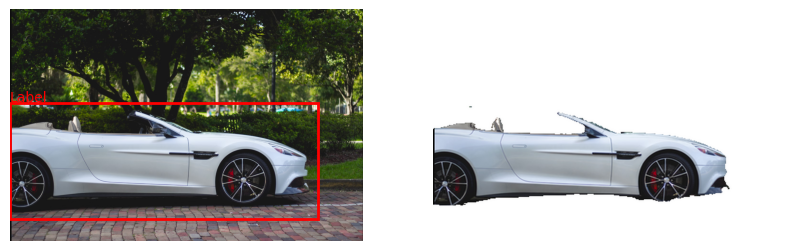

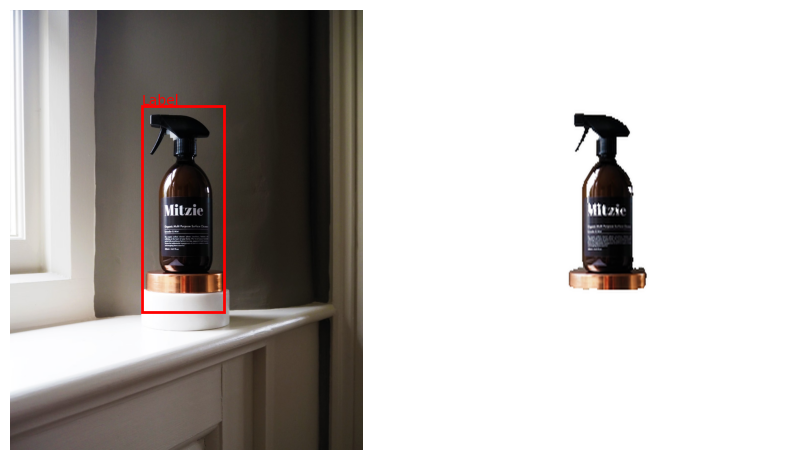

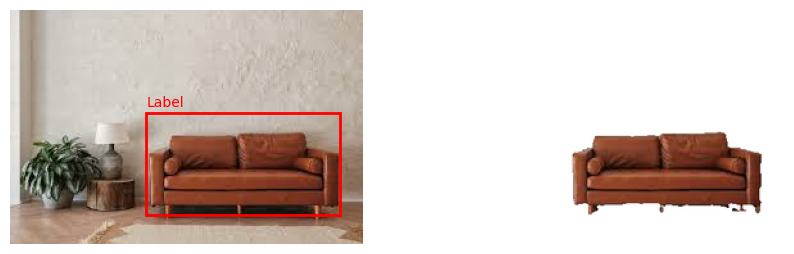

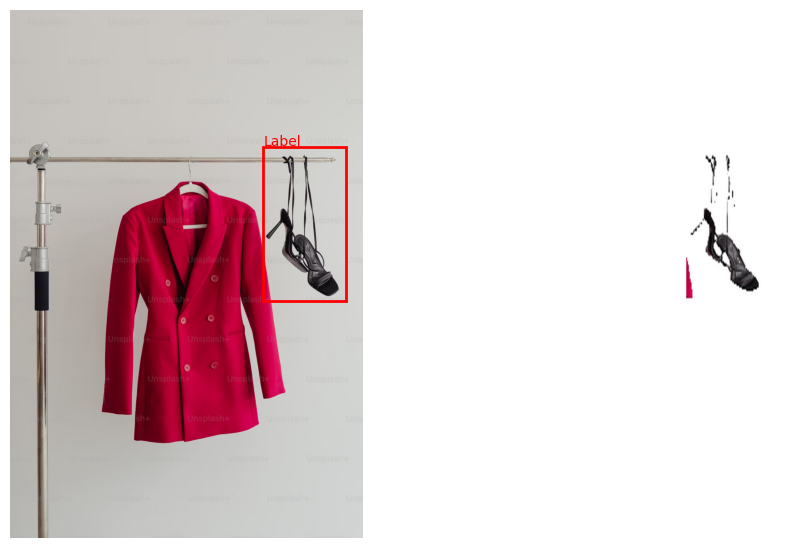

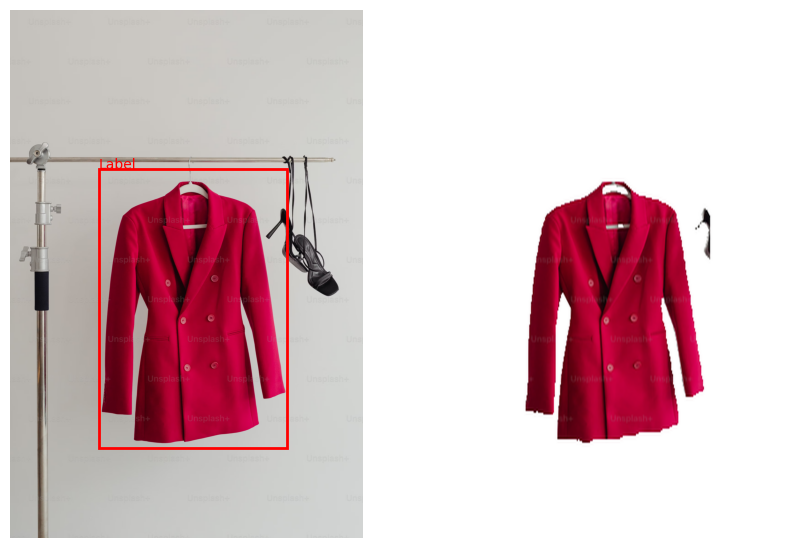

In [146]:
x_min, y_min, width, height = 0, 600, 1980, 750
image_path = "/kaggle/input/cxnfgdxzsa/Screenshot 2024-12-08 162143.png"
show_pipeline(image_path , x_min, y_min, width, height)
x_min, y_min, width, height = 450, 330, 280, 700
image_path = "/kaggle/input/oil-bottel/Screenshot 2024-12-08 160119.png"
show_pipeline(image_path , x_min, y_min, width, height)
x_min, y_min, width, height = 106, 80, 151, 80
image_path = "//kaggle/input/sofa-photo/zxdfxgcnjhu.jpeg"
show_pipeline(image_path , x_min, y_min, width, height)
x_min, y_min, width, height = 2220, 1200, 720, 1350
image_path = "/kaggle/input/new-jacket/premium_photo-1675186049563-000f7ac02c44.jpg"
show_pipeline(image_path , x_min, y_min, width, height)
x_min, y_min, width, height = 780, 1400, 1650, 2440
image_path = "/kaggle/input/new-jacket/premium_photo-1675186049563-000f7ac02c44.jpg"
show_pipeline(image_path , x_min, y_min, width, height)

In [17]:
from remover import show_pipeline


final = show_pipeline(r'C:\Users\sashr\OneDrive\Desktop\nirma\3rd year\semester 5\ML\SVM notes\Screenshot 2024-12-08 162143.png',0, 600, 1980, 750)

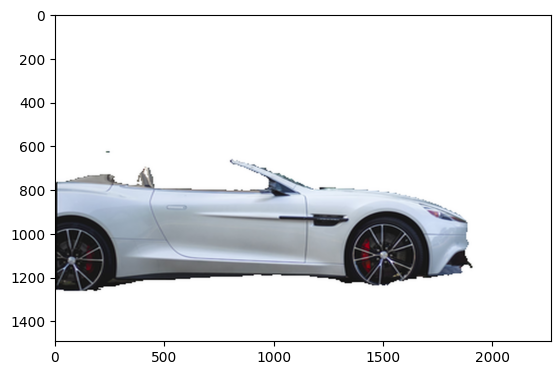

In [6]:
type(final)

numpy.ndarray

In [13]:
import cloudinary
import cloudinary.uploader
from PIL import Image
import os 
# Configure Cloudinary with your credentials
cloudinary.config( 
    cloud_name = "dogfmhpfc", 
    api_key = "187934411863936", 
    api_secret = "hNSE54C0jo1crzIQTyEBF7uRz5g", # Click 'View API Keys' above to copy your API secret
    secure=True
)

def convert_and_upload(image_array, output_path="output.jpg"):
    """
    Converts an image (numpy array) to JPG format, saves it locally, and uploads it to Cloudinary.

    Args:
        image_array (np.array): The image as a numpy array.
        output_path (str): Local path to save the converted JPG image (default: "output.jpg").

    Returns:
        str: URL of the uploaded image on Cloudinary.
    """
    # Convert the numpy array to a PIL Image
    image = Image.fromarray(image_array)

    # Save the image as JPG format
    image.save(output_path, "JPEG")

    # Upload the image to Cloudinary
    response = cloudinary.uploader.upload(output_path)

    os.remove(output_path)

    # Return the URL of the uploaded image
    return response.get("secure_url")



In [14]:
def remove_bg(image_path , x_min , y_min , width , height):
   final = show_pipeline(image_path , x_min, y_min, width, height)
   image_url = convert_and_upload(final)
   print("Uploaded Image URL:", image_url)

In [15]:
final = remove_bg(
    r"C:\Users\sashr\OneDrive\Desktop\nirma\3rd year\semester 5\ML\SVM notes\Screenshot 2024-12-08 160119.png",
     450, 330, 280, 700
)

Uploaded Image URL: https://res.cloudinary.com/dogfmhpfc/image/upload/v1733658087/l00lhxvq5d9m4idtmcp3.jpg


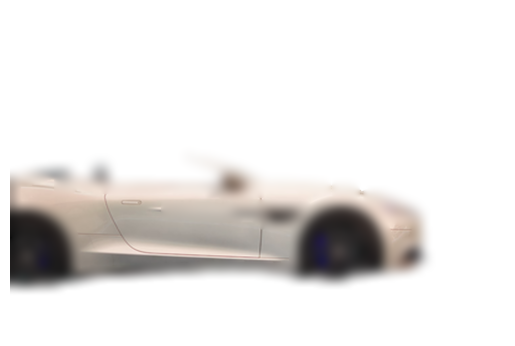

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = final  # Replace 'final' with your image variable (e.g., cv2.imread("path/to/image.jpg"))

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect edges using Canny
edges = cv2.Canny(gray, threshold1=100, threshold2=200)

# Initialize kernel for dilation
kernel = np.ones((3, 3), np.uint8)

# Make a copy of the original image to preserve the unblurred background
original_image = image.copy()

# Create a base mask for dilated edges
dilated_edges = edges.copy()

# Loop for extensive smoothing
for i in range(40):  # Increase the loop count if you want even smoother edges
    # Dilate edges
    dilated_edges = cv2.dilate(dilated_edges, kernel, iterations=1)

    # Create masks
    edge_mask = cv2.bitwise_not(dilated_edges)  # Invert dilated edges for the background mask
    
    # Apply Gaussian blur to the entire image
    blurred = cv2.GaussianBlur(image, (31, 31), 0)  # Large kernel for heavy smoothing

    # Combine blurred edges with the original image
    smoothed_edges = cv2.bitwise_and(blurred, blurred, mask=dilated_edges)
    background = cv2.bitwise_and(original_image, original_image, mask=edge_mask)
    
    # Update the image for the next iteration
    image = cv2.add(smoothed_edges, background)

# Display the result using Matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.axis('off')  # Turn off axis
plt.show()


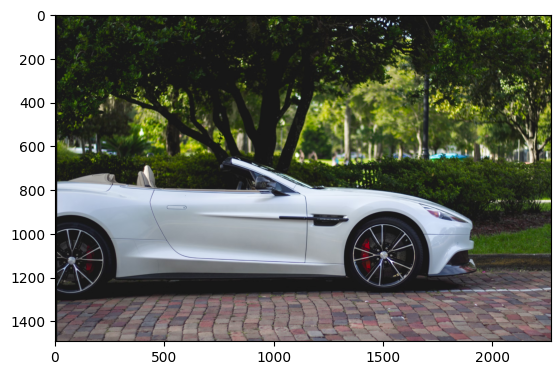

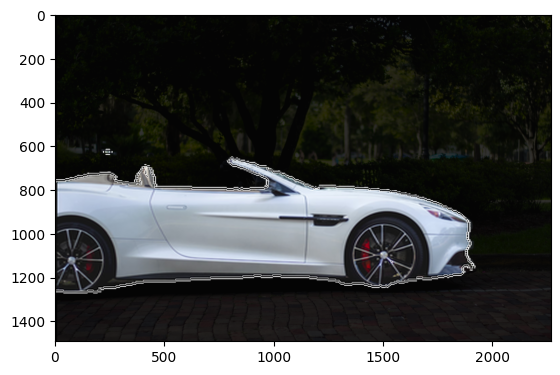

In [65]:
from PIL import Image, ImageEnhance

# Load the images
background_image_path = r"C:\Users\sashr\OneDrive\Desktop\nirma\3rd year\semester 5\ML\SVM notes\Screenshot 2024-12-08 162143.png"
background_image = Image.open(background_image_path).convert("RGB")
# making the image dimmer 
plt.imshow(background_image)
background_image = ImageEnhance.Brightness(background_image).enhance(0.2)


plt.show()
background_array = np.array(background_image)


for i, row in enumerate(background_array):
    for j, pixel in enumerate(row):
        if not (final[i][j][0] == 255 and final[i][j][1] == 255 and final[i][j][2] == 255):
            background_array[i][j] = final[i][j]
      

plt.imshow(background_array)
plt.show()





In [ ]:
def show_pipeline(image_path , x_min, y_min, width, height ):
    # Process image for resizing and bounding box adjustment
    image, (x_min, y_min, width, height), (ow, oh) = resize_image_and_adjust_bbox(image_path, x_min, y_min, width, height)
    image = Image.fromarray(image)
    # Apply the pipeline (ensure input is RGB)
    final = run_pipeline(image ,x_min, y_min, width, height, 2)
    
    # Resize back to original dimensions
    final_image, (x_min_orig, y_min_orig, width_orig, height_orig) = resize_to_original(
        np.array(final), x_min, y_min, width, height, ow, oh
    )
    return final_image